In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import pandas as pd
import seaborn as sns
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
warnings.filterwarnings("ignore", category=FutureWarning)

# Inicializando la sesión Spark
spark = SparkSession.builder.appName("AnalisisCompletoDeDatos").getOrCreate()

# Ruta de la carpeta con los archivos Parquet
ruta = "/Users/felipediegolobatodasilva/Documents/Git/despliegue_analytica/files_parquet/"

# Listar todos los archivos Parquet en la carpeta
archivos_parquet = [f"{ruta}{f}" for f in os.listdir(ruta) if f.endswith('.parquet')]

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Cargar el DataFrame en pysapark
df_base_spark = spark.read.parquet('/Users/felipediegolobatodasilva/Desktop/git/despliegue_analytica/files_parquet/df_joined_cleaned_no_nulls.parquet')

# Diccionario para renombrar las columnas al español
nombres_columnas_espanol = {
    'order_id': 'id_pedido',
    'seller_id': 'id_vendedor',
    'product_id': 'id_producto',
    'customer_id': 'id_cliente',
    'order_status': 'estado_pedido',
    'order_purchase_timestamp': 'fecha_compra_pedido',
    'order_approved_at': 'fecha_aprobacion_pedido',
    'order_estimated_delivery_date': 'fecha_entrega_estimada',
    'order_item_id': 'id_item_pedido',
    'shipping_limit_date': 'fecha_limite_envio',
    'price': 'precio',
    'freight_value': 'valor_flete',
    'payment_sequential': 'secuencia_pago',
    'payment_type': 'tipo_pago',
    'payment_installments': 'cuotas_pago',
    'payment_value': 'valor_pago',
    'customer_unique_id': 'id_unico_cliente',
    'customer_zip_code_prefix': 'codigo_postal_cliente',
    'customer_city': 'ciudad_cliente',
    'customer_state': 'estado_cliente',
    'product_category_name': 'nombre_categoria_producto',
    'product_name_lenght': 'longitud_nombre_producto',
    'product_description_lenght': 'longitud_descripcion_producto',
    'product_photos_qty': 'cantidad_fotos_producto',
    'product_weight_g': 'peso_producto_g',
    'product_length_cm': 'largo_producto_cm',
    'product_height_cm': 'altura_producto_cm',
    'product_width_cm': 'ancho_producto_cm',
    'seller_zip_code_prefix': 'codigo_postal_vendedor',
    'seller_city': 'ciudad_vendedor',
    'seller_state': 'estado_vendedor'
}

# Renombrar las columnas en el DataFrame de PySpark
for old_name, new_name in nombres_columnas_espanol.items():
    df_base_spark = df_base_spark.withColumnRenamed(old_name, new_name)

# Mostrar las columnas renombradas y la cantidad de registros
print("Columnas de df_base_spark:", df_base_spark.columns)
print("\nCantidad de registros de df_base_spark:", df_base_spark.count())

: 

In [2]:
/opt/homebrew/bin/python3 -m pip install ipykernel -U --user --force-reinstall


NameError: name 'opt' is not defined

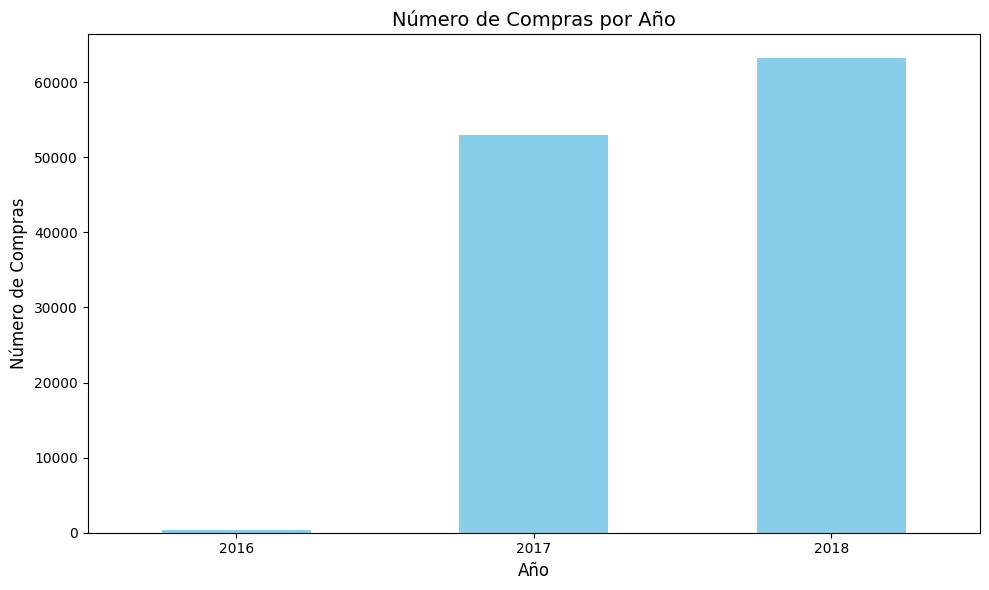

In [32]:
#Separemos la fecha y hora del campo fecha_compra_pedido
# Crear columna solo con la fecha
df_base['fecha_pedido'] = df_base['fecha_compra_pedido'].dt.date

# Crear columna solo con la hora
df_base['hora_compra_pedido'] = df_base['fecha_compra_pedido'].dt.time

#Revisemos la cantidad de registros por fecha en que se realizo la compra
# Extrae solo el año de la fecha
df_base['anio_compra_pedido'] = df_base['fecha_compra_pedido'].dt.year

# Agrupa por año y cuenta el número de ocurrencias
anio_counts = df_base['anio_compra_pedido'].value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
anio_counts.plot(kind='bar', color='skyblue')

# Añadir título y etiquetas
plt.title('Número de Compras por Año', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Compras', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [33]:
#Creando el campo temporada
# Extraer el mes
df_base['month'] = df_base['fecha_compra_pedido'].dt.month

# Función para asignar la temporada
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

# Aplicar la función para crear la columna de temporada
df_base['temporada'] = df_base['month'].apply(assign_season)

In [34]:
#para el ejercicio del proyecto solo seleccionaremos los campos del año 2018
df_baseFinal=df_base[df_base['anio_compra_pedido']>=2018]
columnas2=['id_pedido', 'id_vendedor', 'id_producto', 'id_cliente',
       'estado_pedido', 'fecha_pedido','hora_compra_pedido', 'fecha_aprobacion_pedido',
       'fecha_entrega_estimada', 'id_item_pedido', 'fecha_limite_envio',
       'precio', 'valor_flete', 'secuencia_pago', 'tipo_pago', 'cuotas_pago',
       'valor_pago', 'id_unico_cliente', 'codigo_postal_cliente',
       'ciudad_cliente', 'estado_cliente', 'nombre_categoria_producto',
       'longitud_nombre_producto', 'longitud_descripcion_producto',
       'cantidad_fotos_producto', 'peso_producto_g', 'largo_producto_cm',
       'altura_producto_cm', 'ancho_producto_cm', 'codigo_postal_vendedor',
       'ciudad_vendedor', 'estado_vendedor','temporada']
df_baseFinal=df_baseFinal[columnas2]
df_baseFinal.shape

(63219, 33)

In [36]:
#Guardemos el archivo final en dvc
df_baseFinal.to_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')